In [1]:
!pip install pmdarima

In [136]:
# import needed libraries
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from scipy import signal
from sklearn.metrics import mean_squared_error
import statsmodels.api as sn
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [98]:
# read the CSV file
df = pd.read_csv(r'C:\Users\Saemi\OneDrive\Education\WGU\D213 Advanced Data Analytics\PA\PA1 Time Series Modeling\medical_time_series.csv')
# check the data information
df.shape

(731, 2)

In [99]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [101]:
df.isnull().any()

Day        False
Revenue    False
dtype: bool

In [102]:
cleaned_df = df.dropna()

In [103]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [104]:
cleaned_df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,14.179608
std,211.165812,6.959905
min,1.000000,-4.423299
25%,183.500000,11.121742
50%,366.000000,15.951830
75%,548.500000,19.293506
max,731.000000,24.792249


In [105]:
#Convert Day to a Date as time series model like a date structure
cleaned_df['Date'] = (pd.date_range(start = datetime(2020, 1, 1),
              periods = cleaned_df.shape[0], freq='24H'))
#Set the Date as an index
cleaned_df.set_index('Date', inplace=True)
cleaned_df = cleaned_df.drop('Day', axis = 1)
cleaned_df

,Revenue
Date,
2020-01-01,0.000000
2020-01-02,-0.292356
2020-01-03,-0.327772
2020-01-04,-0.339987
2020-01-05,-0.124888
...,...
2021-12-27,15.722056
2021-12-28,15.865822
2021-12-29,15.708988


In [106]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2020-01-01 to 2021-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [107]:
#Save the cleaned datset
cleaned_df.to_csv('cleaned_data.csv')

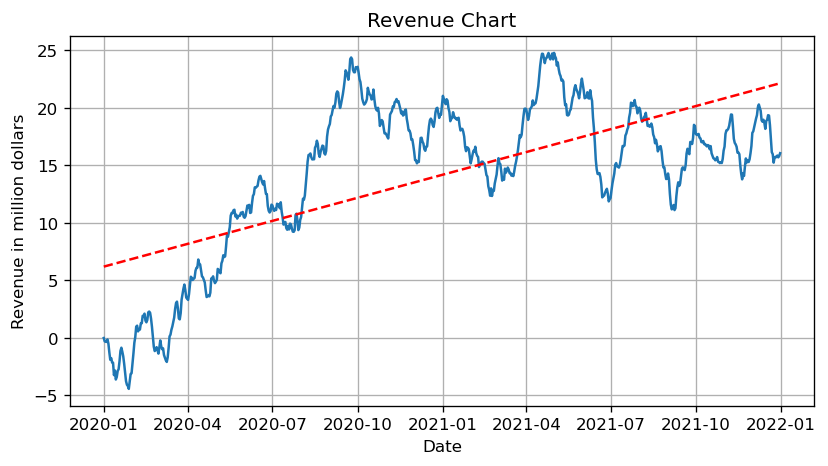

In [108]:
#Visualize the data
plt.figure(figsize=(8,4))
plt.plot(cleaned_df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue in million dollars')

#Generate trend line
x = mdates.date2num(cleaned_df.index)
y = cleaned_df.Revenue
z = np.polyfit(x,y,1)
p = np.poly1d(z)

plt.plot(x, p(x), "r--")
plt.grid(True)
plt.show()

In [109]:
#Checking for stationarity using the Adfuller (Augmented Dickey-Fuller) Test
result = adfuller(cleaned_df['Revenue'])
print("Test statistics: ", result[0])

#p-value indicates the order of the lag or the difference btwn the present & past data
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -2.2183190476089436
p-value:  0.199664006150644
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [110]:
#Check if it is stationary time series or not
if result[1] <= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Fail to reject null hypothesis, the time series is non-stationary


In [111]:
#Make the time series stationary
#Differentiate the data here
df_stationary = cleaned_df.diff(periods=1,axis=0).dropna()
#View the data
df_stationary.head()

,Revenue
Date,
2020-01-02,-0.292356
2020-01-03,-0.035416
2020-01-04,-0.012215
2020-01-05,0.215100
2020-01-06,-0.366702


In [112]:
#Test for stationarity again
result = adfuller(df_stationary['Revenue'])
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[1] <= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Test statistics:  -17.374772303557066
p-value:  5.113206978840171e-30
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


In [113]:
#Save the stationary datset
df_stationary.to_csv('stationary_data.csv')

In [114]:
#Splitting the data to train and test sets
train = cleaned_df.loc[:'2021-09-30']
test = cleaned_df.loc['2021-10-01':]
print('Training Set: ', train.shape)
print('Test Set: ', test.shape)

Training Set:  (639, 1)
Test Set:  (92, 1)


In [115]:
#Save the train & test datset
train.to_csv('train_data.csv')
test.to_csv('test_data.csv')

In [116]:
#Seasonality has 90 days of cycle
#(i.e. repeating pattern for a 90-day fixed period)
#Using a non-stationary data
decomp = seasonal_decompose(cleaned_df['Revenue'], period=90)

<Axes: title={'center': 'Seasonality'}, xlabel='Date'>

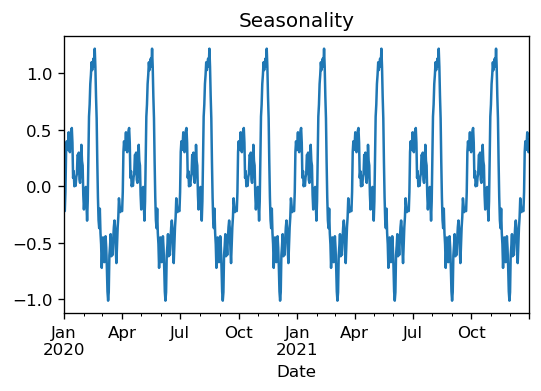

In [117]:
#Plot seasonality from the non-stationary data whose value is in the variable decomp
plt.title('Seasonality')
decomp.seasonal.plot()

<Axes: title={'center': 'Trend'}, xlabel='Date'>

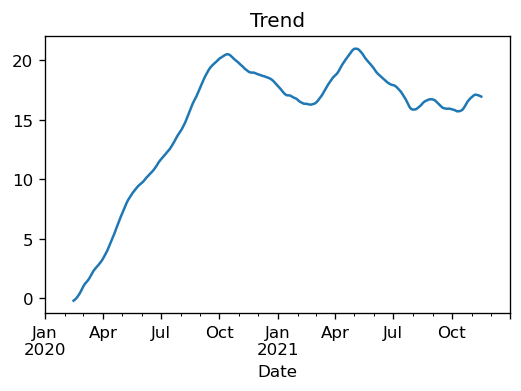

In [118]:
plt.title('Trend')
decomp.trend.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

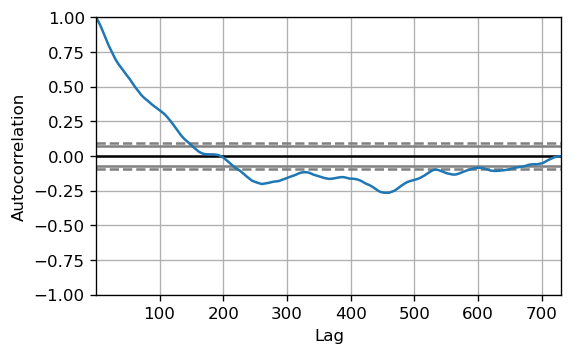

In [119]:
#Continue Looking for Seasonality data
#Autocorrelation plot of a non-stationary data
plt.rcParams.update({'figure.figsize':(5,3),
                     'figure.dpi':120})
pd.plotting.autocorrelation_plot(cleaned_df.Revenue.tolist())

(array([1.52612936e+04, 8.12118786e+03, 2.62760550e+02, 1.24454986e+02,
        5.40026379e+01, 2.55196420e+01, 2.89237553e+01, 6.29449800e+00,
        8.38967529e+00, 8.79735213e+00, 3.26244345e+00, 5.16464998e+00,
        4.64370619e+00, 1.96867736e+00, 1.48167320e+00, 2.11256649e+00,
        1.08550271e+00, 5.81988645e-01, 2.76744723e+00, 2.22308983e+00,
        5.50876230e-01, 7.49752606e-01, 1.26157210e+00, 8.77859381e-01,
        4.84404330e-01, 4.39565525e-01, 2.05055025e-01, 9.50457901e-01,
        5.23499207e-01, 4.35456489e-01, 1.69884060e+00, 8.97977002e-01,
        7.28275718e-01, 6.11527179e-01, 1.49053313e+00, 5.44383887e-01,
        2.17350902e-01, 5.07814496e-01, 4.43820257e-01, 2.94184611e-01,
        2.55373626e-01, 9.44702588e-02, 1.58619217e-01, 1.88829134e-01,
        2.11804293e-01, 6.04121179e-01, 4.95073852e-01, 2.15698285e-01,
        1.04432711e-01, 1.46393379e-01, 2.07457981e-01, 1.26602668e-01,
        1.74592665e-01, 1.42674366e-01, 9.63196690e-02, 1.177682

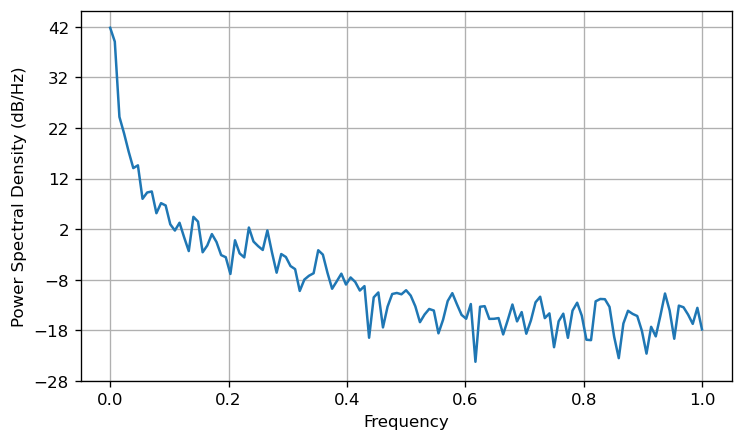

In [120]:
#Example 1: displaying Power Spectral density using non-stationarity revenue data
plt.figure(figsize=(7,4), linewidth=3)
plt.psd(cleaned_df['Revenue'])

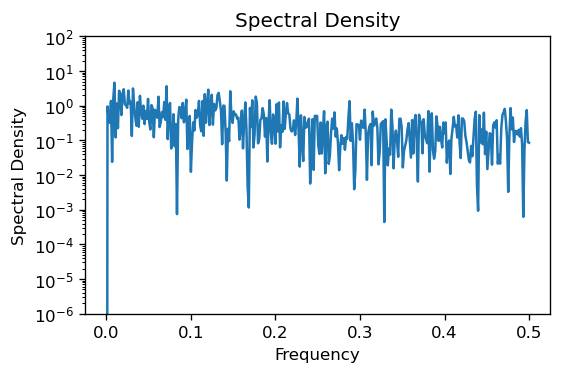

In [121]:
#Example 2: displaying Power Spectral density using the stationarity data
f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

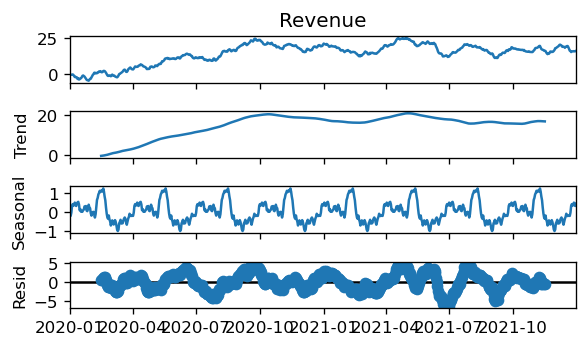

In [122]:
#plot decomposition
decomp.plot()
plt.show()

<Axes: title={'center': 'Residual'}, xlabel='Date'>

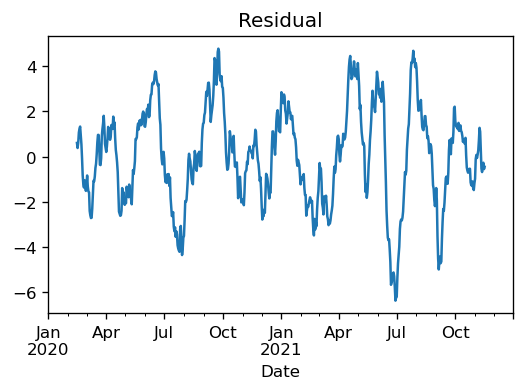

In [123]:
plt.title('Residual')
decomp.resid.plot()

In [124]:
#Find the best model using auto-ARIMA
model = auto_arima(train['Revenue'], trace=True, suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=782.828, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=895.175, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=780.955, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=801.272, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=895.419, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=782.951, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=782.952, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=782.178, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=779.867, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=781.858, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=781.860, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=800.680, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=781.053, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.682 seconds
                               SARI

In [125]:
model = ARIMA(train, order=(1,1,0))
results = model.fit()
results.summary()

C:\Users\Saemi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Saemi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Saemi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  639
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -387.933
Date:                Fri, 11 Oct 2024   AIC                            779.867
Time:                        20:34:55   BIC                            788.784
Sample:                    01-01-2020   HQIC                           783.328
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4100      0.037     11.194      0.000       0.338       0.482
sigma2         0.1975      0.012     16.543      0.000       0.174       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.94   Prob(JB):                         0.35
Heteroskedasticity (H):               1.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
#Make out of Sample Forecast
results.forecast(92)

2021-10-01    18.382233
2021-10-02    18.364138
2021-10-03    18.356718
2021-10-04    18.353677
2021-10-05    18.352430
2021-10-06    18.351918
2021-10-07    18.351709
2021-10-08    18.351623
2021-10-09    18.351587
2021-10-10    18.351573
2021-10-11    18.351567
2021-10-12    18.351565
2021-10-13    18.351564
2021-10-14    18.351563
2021-10-15    18.351563
2021-10-16    18.351563
2021-10-17    18.351563
2021-10-18    18.351563
2021-10-19    18.351563
2021-10-20    18.351563
2021-10-21    18.351563
2021-10-22    18.351563
2021-10-23    18.351563
2021-10-24    18.351563
2021-10-25    18.351563
2021-10-26    18.351563
2021-10-27    18.351563
2021-10-28    18.351563
2021-10-29    18.351563
2021-10-30    18.351563
2021-10-31    18.351563
2021-11-01    18.351563
2021-11-02    18.351563
2021-11-03    18.351563
2021-11-04    18.351563
2021-11-05    18.351563
2021-11-06    18.351563
2021-11-07    18.351563
2021-11-08    18.351563
2021-11-09    18.351563
2021-11-10    18.351563
2021-11-11    18

In [127]:
#Create future dates after the dataset
index_future_dates = pd.date_range(start='2021-10-01', end='2021-12-31')
print(index_future_dates)

DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10', '2021-10-11', '2021-10-12',
               '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-16',
               '2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20',
               '2021-10-21', '2021-10-22', '2021-10-23', '2021-10-24',
               '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28',
               '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01',
               '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
               '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09',
               '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13',
               '2021-11-14', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19', '2021-11-20', '2021-11-21',
               '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-25',
      

In [132]:
pred = results.predict(start=len(train), end=len(train)+91, typ='levels')
pred.index = index_future_dates
pred.head()

2021-10-01    18.382233
2021-10-02    18.364138
2021-10-03    18.356718
2021-10-04    18.353677
2021-10-05    18.352430
Freq: D, Name: predicted_mean, dtype: float64

In [133]:
prediction = pd.DataFrame(pred, index=test.index)
prediction.columns=['Revenue']
prediction.head()

,Revenue
Date,
2021-10-01,18.382233
2021-10-02,18.364138
2021-10-03,18.356718
2021-10-04,18.353677
2021-10-05,18.352430


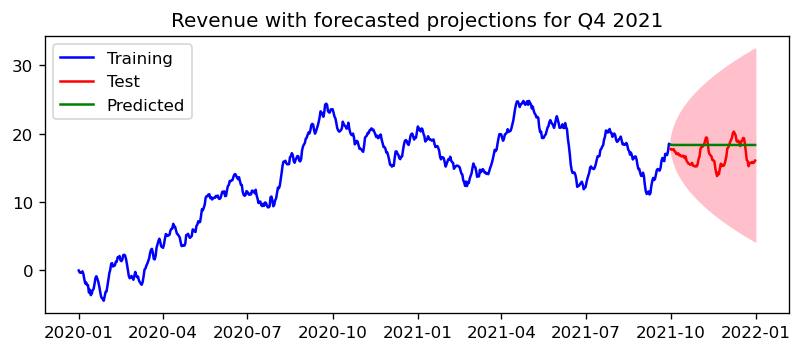

In [142]:
diff_forecast = results.get_forecast(steps=92)
mean_forecast = diff_forecast.predicted_mean
#Get confidence intervals of predictions
confidence_intervals = diff_forecast.conf_int()
#Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

plt.figure(figsize=(8,3))
plt.plot(train,label="Training",color='b')
plt.plot(test,label="Test",color='r')
plt.plot(prediction,label="Predicted",color='g')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('Revenue with forecasted projections for Q4 2021')
plt.legend(loc = 'upper left')

In [137]:
#Calculate root mean squared error of forecasted data against the observed data
rmse = mean_squared_error(test, prediction, squared=False)
print('The rmse of the prediction is ', rmse)

The rmse of the prediction is  2.0836449676173965


C:\Users\Saemi\AppData\Local\Temp\ipykernel_8272\792183438.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  results.plot_diagnostics().show()


<Figure size 3600x3600 with 0 Axes>

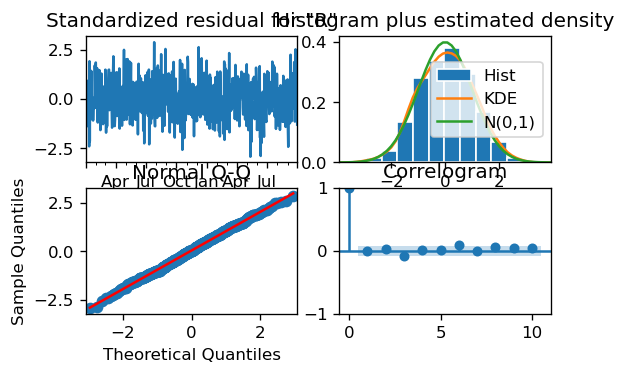

In [151]:
#Create the 4 diagnostic plots
results.plot_diagnostics().show()